In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from src.etl import get_train_test_data

In [3]:
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a presentation
    sns.set_context("talk")
    
    # Set the font to be serif, rather than sans
    sns.set_theme(font='serif', font_scale=2, rc = {'figure.figsize': (15,8)})
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("whitegrid", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
set_style()
colors = sns.color_palette("pastel", 2)

In [4]:
df, _ = get_train_test_data(train_only=True)

<AxesSubplot: title={'center': 'Tumor Type Counts'}>

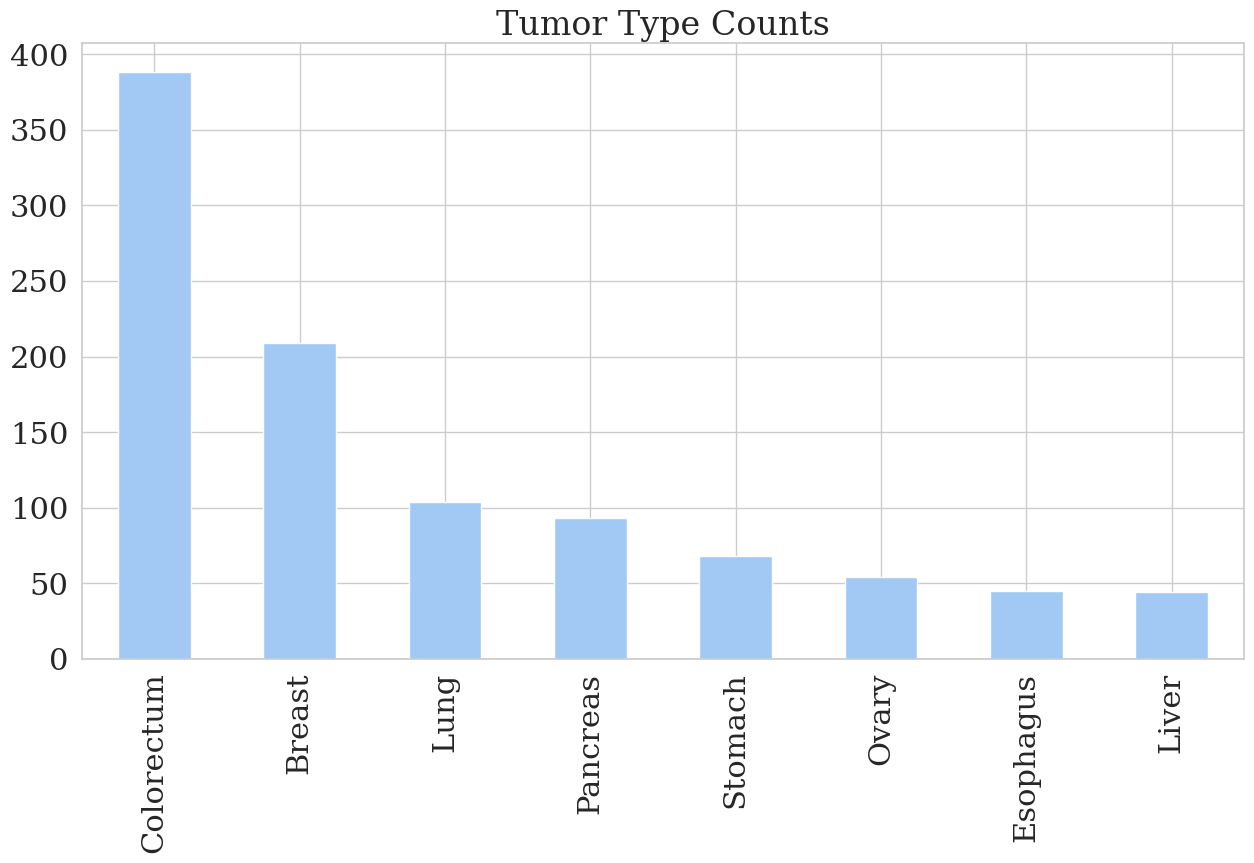

In [5]:
df.tumor_type.value_counts().drop("Normal").plot(
    kind="bar", title="Tumor Type Counts", color = colors[0])

<AxesSubplot: title={'center': 'Count of Cancer vs. Normal Samples'}>

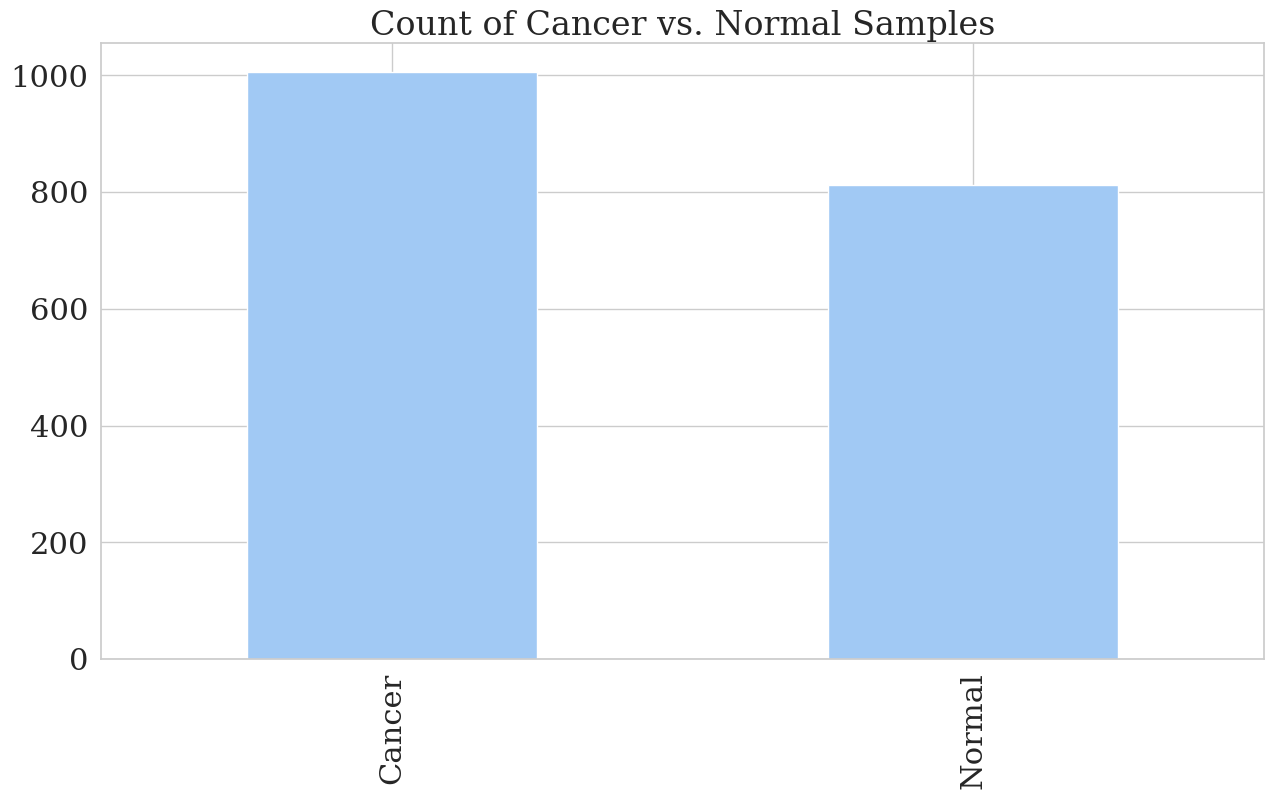

In [6]:
df.assign(cancer = df.tumor_type != "Normal").cancer.map(
    {True: "Cancer", False: "Normal"}).value_counts().plot(
        kind="bar", title="Count of Cancer vs. Normal Samples", color = colors[0])

In [7]:
from config import MUTATION_COL

<AxesSubplot: title={'center': 'Distribution of mutations per gene in whole cohort'}>

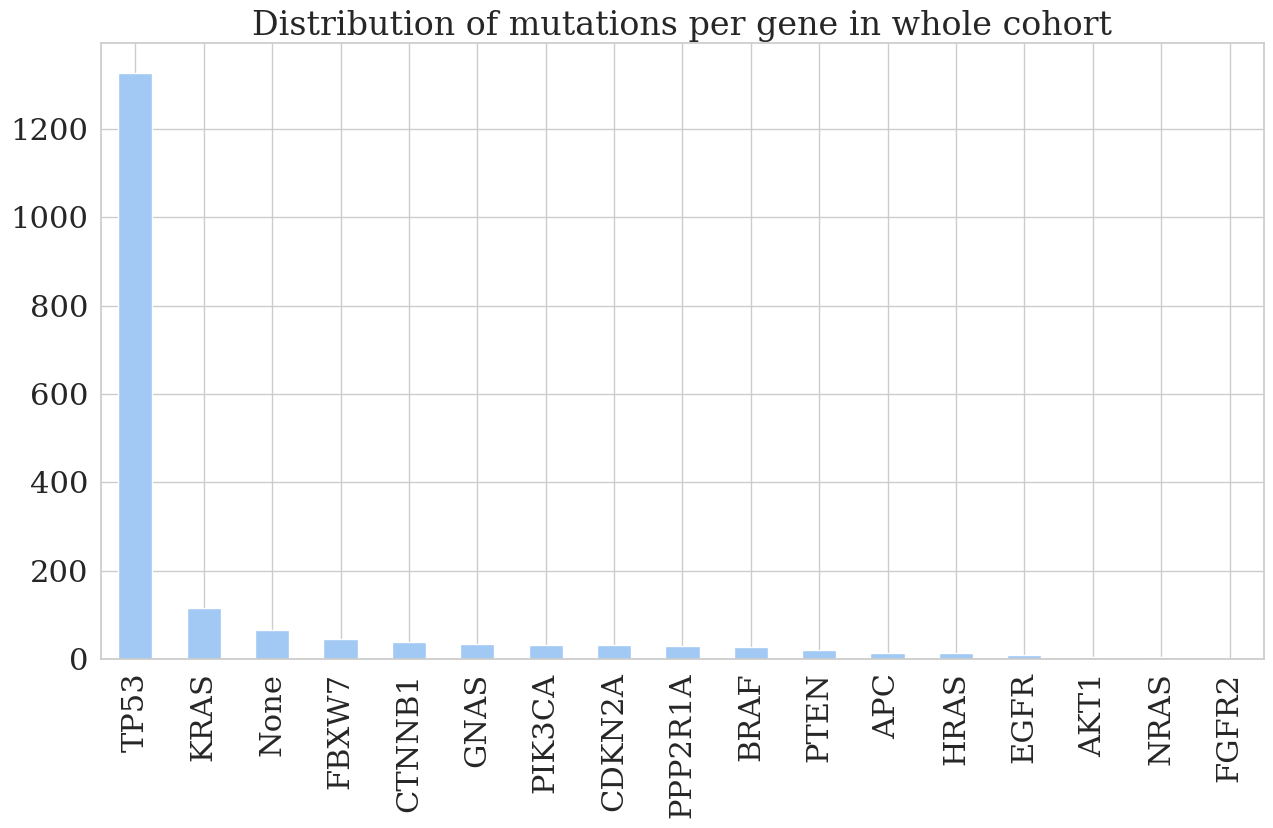

In [8]:
df[MUTATION_COL].str.split(' ').apply(
    lambda x: x[0]).value_counts().plot(
        kind="bar",
        title = "Distribution of mutations per gene in whole cohort", color = colors[0])

In [9]:
import pandas as pd
from config import NON_CANCER_STATUS

In [10]:
def get_gene_name(mutation_string):
    if pd.isna(mutation_string):
        return None
    return str(mutation_string).split(' ')[0]

In [11]:
total_mutations = df[MUTATION_COL].apply(get_gene_name).value_counts()
cancer_patients_df = df[df['tumor_type'] != NON_CANCER_STATUS]
cancer_mutations = cancer_patients_df[MUTATION_COL].apply(get_gene_name).value_counts()

In [12]:
mutations_df = pd.DataFrame({
    'Total Mutations': total_mutations,
    'Mutations in Cancer Patients': cancer_mutations
})

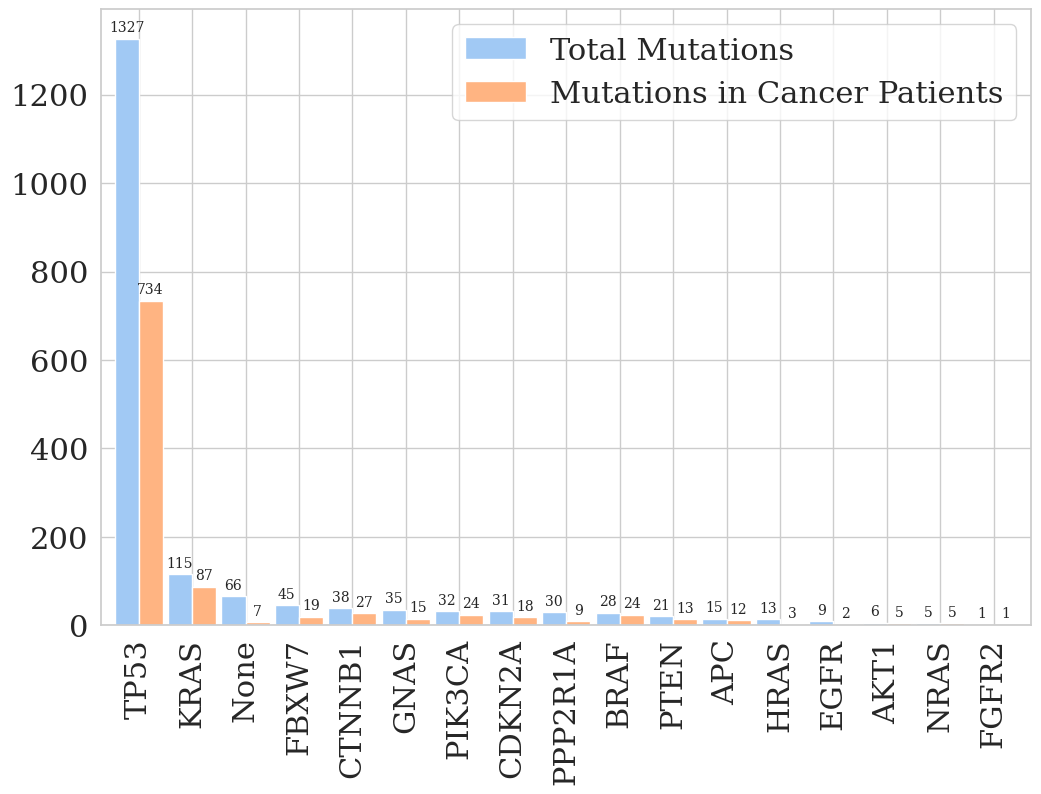

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
mutations_df.sort_values(by='Total Mutations', ascending=False).plot(kind='bar', ax=ax, rot=90, width=0.9, color = colors)
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, padding=3)

In [14]:
df_filtered = df.copy()
df_filtered['gene_name'] = df_filtered[MUTATION_COL].apply(get_gene_name)
df_filtered = df_filtered.query('gene_name != "None"', engine="python")
df_filtered['cancer'] = df.assign(cancer = df.tumor_type != "Normal").cancer.map(
    {True: "C.", False: "N."})
df_filtered = df_filtered.dropna(subset=['cancer', 'gene_name', 'omega_score'])

Text(0.5, 1.03, 'Distribution of Omega Score by Gene')

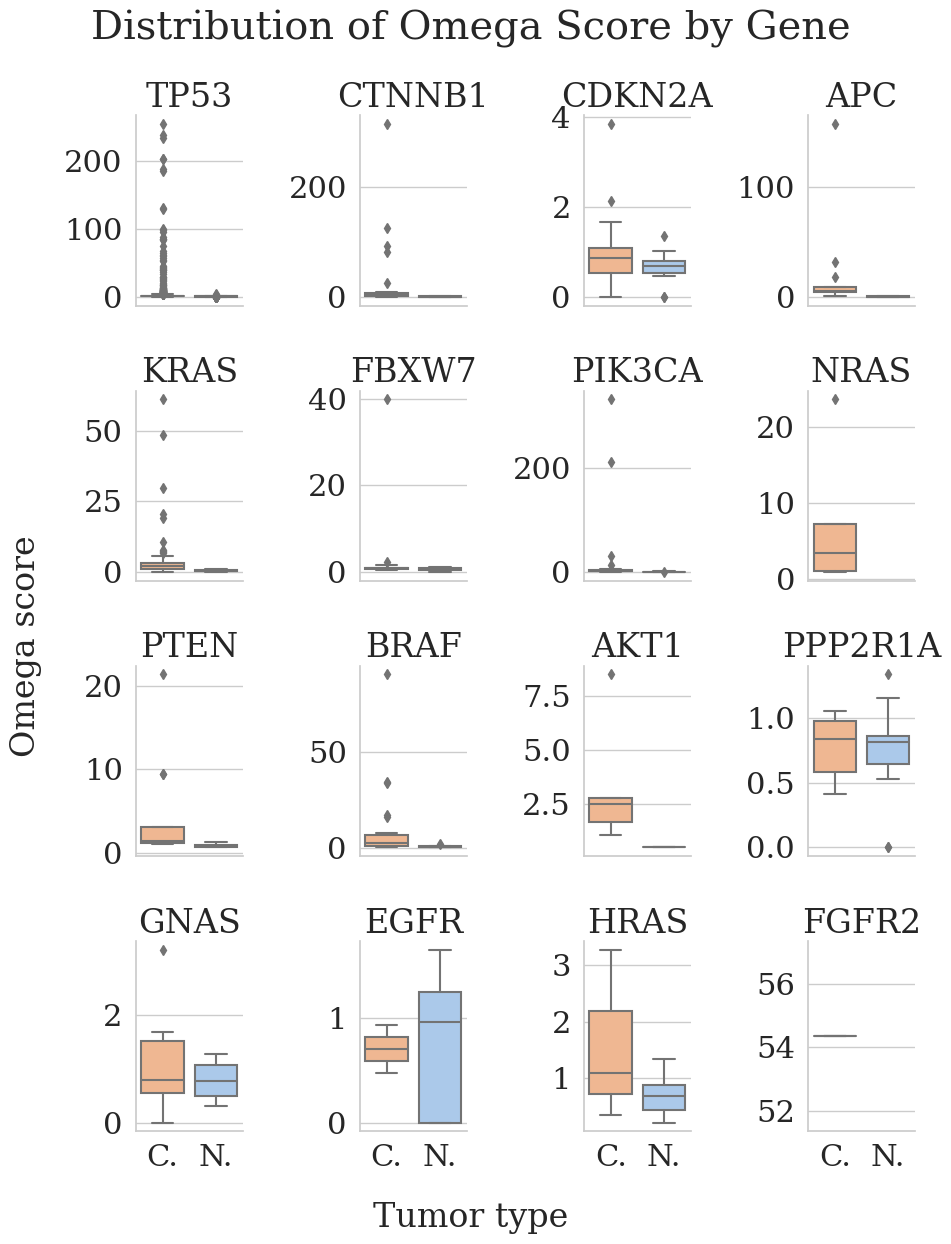

In [15]:
custom_palette = {'N.': colors[0], 'C.': colors[1]}
p = sns.catplot(
    data=df_filtered,
    x='cancer',
    y='omega_score',
    col='gene_name',
    kind='box',
    col_wrap=4,
    height=3,
    aspect=0.8,
    palette=custom_palette,
    sharey=False, 
)
p.set_axis_labels("", "")
p.figure.supylabel("Omega score", fontsize=24)
p.figure.supxlabel("Tumor type", fontsize=24)
p.set_titles("{col_name}")
p.figure.suptitle("Distribution of Omega Score by Gene", y=1.03)

In [16]:
import numpy as np
from scipy.stats import norm

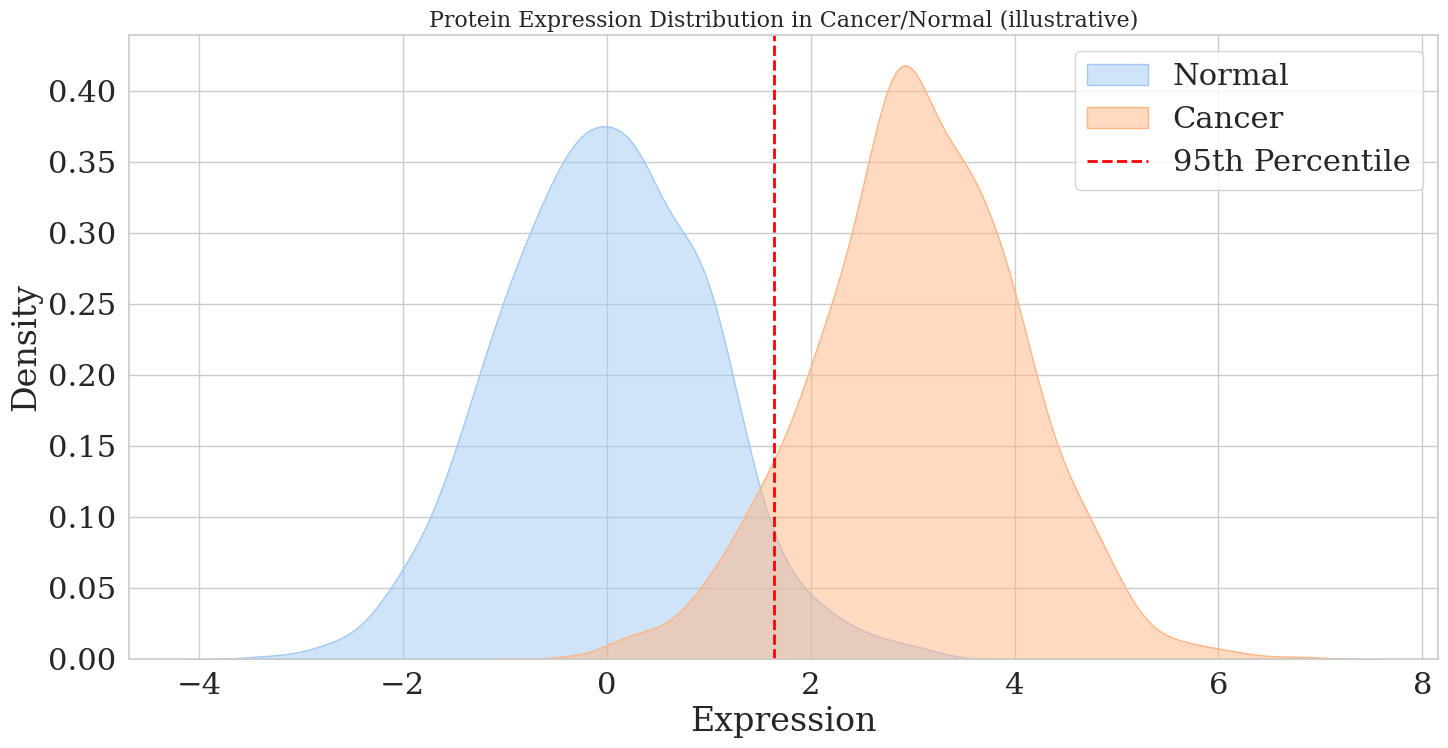

In [17]:
mean_normal = 0
std_normal = 1
mean_cancer = 3
std_cancer = 1 

normal_data = np.random.normal(mean_normal, std_normal, 1000)
cancer_data = np.random.normal(mean_cancer, std_cancer, 1000)

sns.kdeplot(normal_data, label='Normal', fill=True, color=colors[0], alpha=0.5)
sns.kdeplot(cancer_data, label='Cancer', fill=True, color=colors[1], alpha=0.5)

percentile_95 = norm.ppf(0.95, loc=mean_normal, scale=std_normal)

# Draw the vertical line at the 95th percentile
plt.axvline(
    x=percentile_95,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'95th Percentile'
)

# Add title, labels, and legend
plt.title('Protein Expression Distribution in Cancer/Normal (illustrative)', fontsize=16)
plt.xlabel('Expression', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.legend()
plt.tight_layout()

In [18]:
from pathlib import Path
import pickle
from config import DATA_DIR

In [19]:
with open(Path(DATA_DIR, "baseline_results.pkl"), "rb") as f:
    results = pickle.load(f)

In [20]:
with open(Path(DATA_DIR, "model_results.pkl"), "rb") as f:
    model_cv_error, model_df = pickle.load(f)

In [21]:
from src.utils import add_roc_curve_to_ax, make_class_names
from src.utils import plot_confusion_matrix, calculate_sens_spec, calculate_sens_spec_per_class
from IPython.display import Markdown

In [22]:
def get_meta_data(df):
    y_true = df.true_label
    y_pred = df.predicted_label
    y_pred_probs = 1 - df.prob_normal
    class_names = make_class_names(df)
    return y_true, y_pred, y_pred_probs, class_names

In [23]:
df = results["dataframe"]
y_true, y_pred, y_pred_probs, class_names = get_meta_data(df)

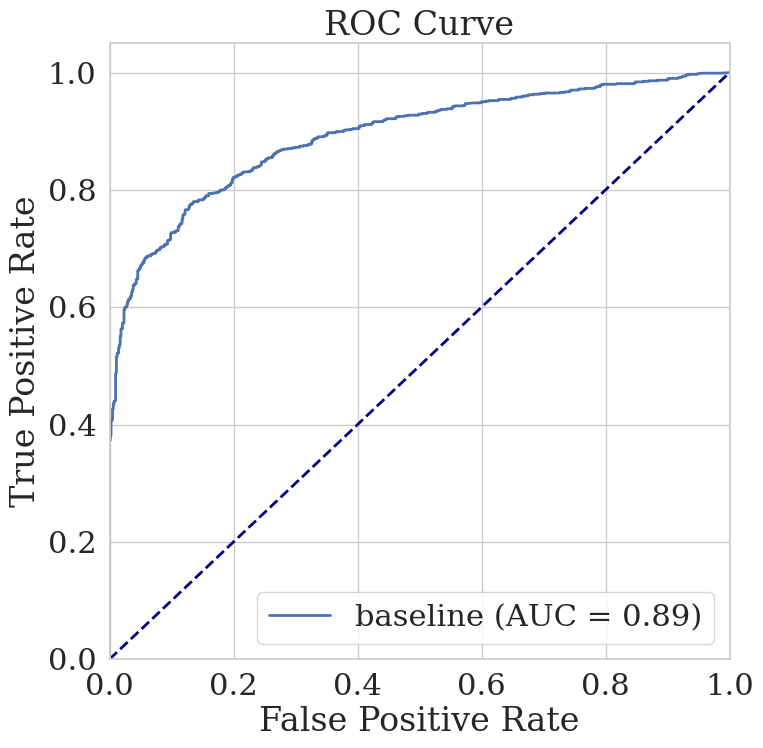

In [43]:
fig, ax = add_roc_curve_to_ax(y_true, y_pred_probs, "baseline")

In [24]:
y_true_m, y_pred_m, y_pred_probs_m, _ = get_meta_data(model_df)

In [25]:
calculate_sens_spec(df), calculate_sens_spec(model_df)

((0.6208955223880597, 0.9655172413793104),
 (0.6348258706467662, 0.9605911330049262))

In [ ]:
Markdown(df)

In [33]:
Markdown(calculate_sens_spec_per_class(y_true, y_pred, class_names).to_markdown())

|            |   sensitivity |   specificity |
|:-----------|--------------:|--------------:|
| Breast     |     0.0143541 |      0.987562 |
| Colorectum |     0.603093  |      0.785864 |
| Esophagus  |     0         |      0.997178 |
| Liver      |     0.0454545 |      0.994924 |
| Lung       |     0         |      0.996497 |
| Normal     |     0.965517  |      0.620896 |
| Ovary      |     0.333333  |      0.997731 |
| Pancreas   |     0.225806  |      0.9942   |
| Stomach    |     0.0588235 |      0.994282 |

In [34]:
Markdown(calculate_sens_spec_per_class(y_true_m, y_pred_m, class_names).to_markdown())

|            |   sensitivity |   specificity |
|:-----------|--------------:|--------------:|
| Breast     |     0.0430622 |      0.9801   |
| Colorectum |     0.53866   |      0.79846  |
| Esophagus  |     0.0444444 |      0.996614 |
| Liver      |     0.181818  |      0.99436  |
| Lung       |     0.115385  |      0.991827 |
| Normal     |     0.960591  |      0.634826 |
| Ovary      |     0.481481  |      0.988656 |
| Pancreas   |     0.11828   |      0.993039 |
| Stomach    |     0.0441176 |      0.995426 |

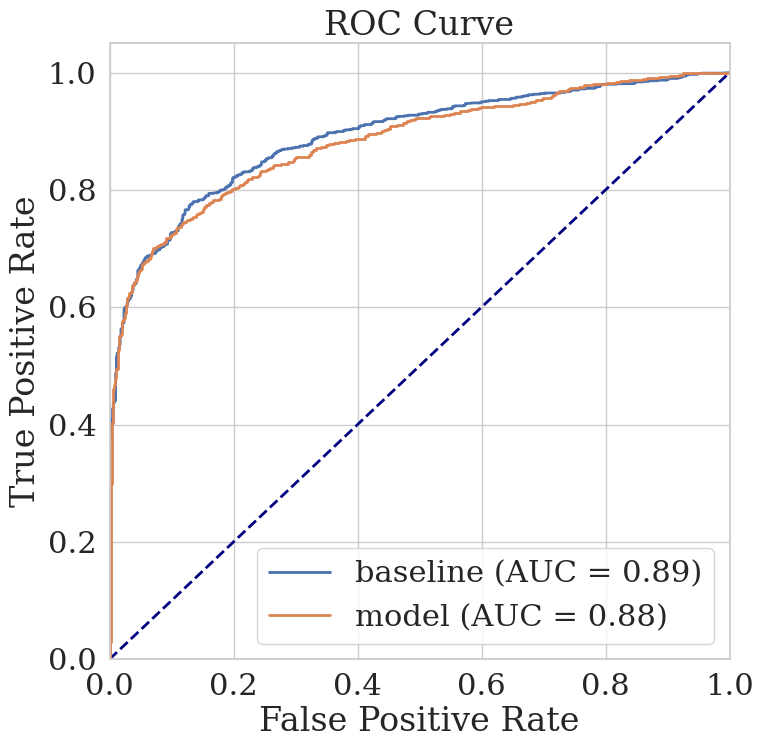

In [ ]:
fig, ax = add_roc_curve_to_ax(y_true_m, y_pred_probs_m, "my model", ax = ax)
fig

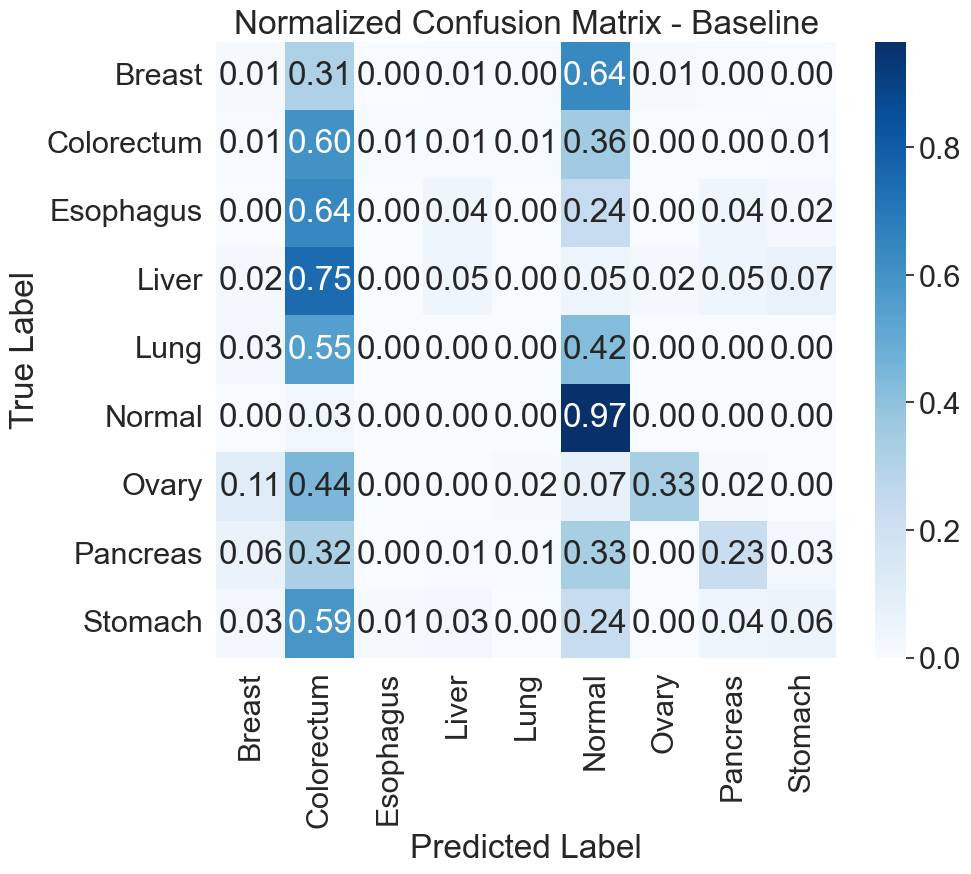

In [29]:
plot_confusion_matrix(y_true, y_pred, class_names, label = "Baseline")

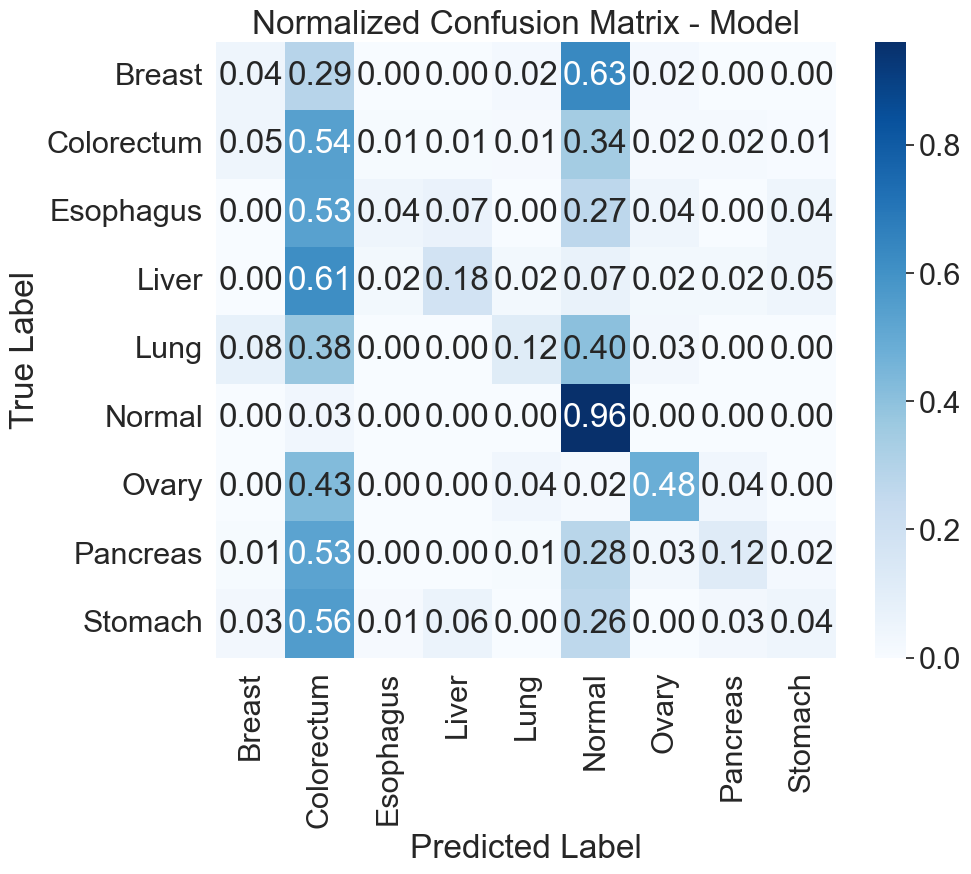

In [30]:
plot_confusion_matrix(y_true_m, y_pred_m, class_names, label = "Model")

In [46]:
import os

In [47]:
df = pd.read_excel(
        os.path.join(DATA_DIR, "NIHMS982921-supplement-Tables_S1_to_S11.xlsx"),
        sheet_name="Table S1",
        skiprows=2,
        skipfooter=2,
    )

<AxesSubplot: title={'center': 'Amplicons per gene'}>

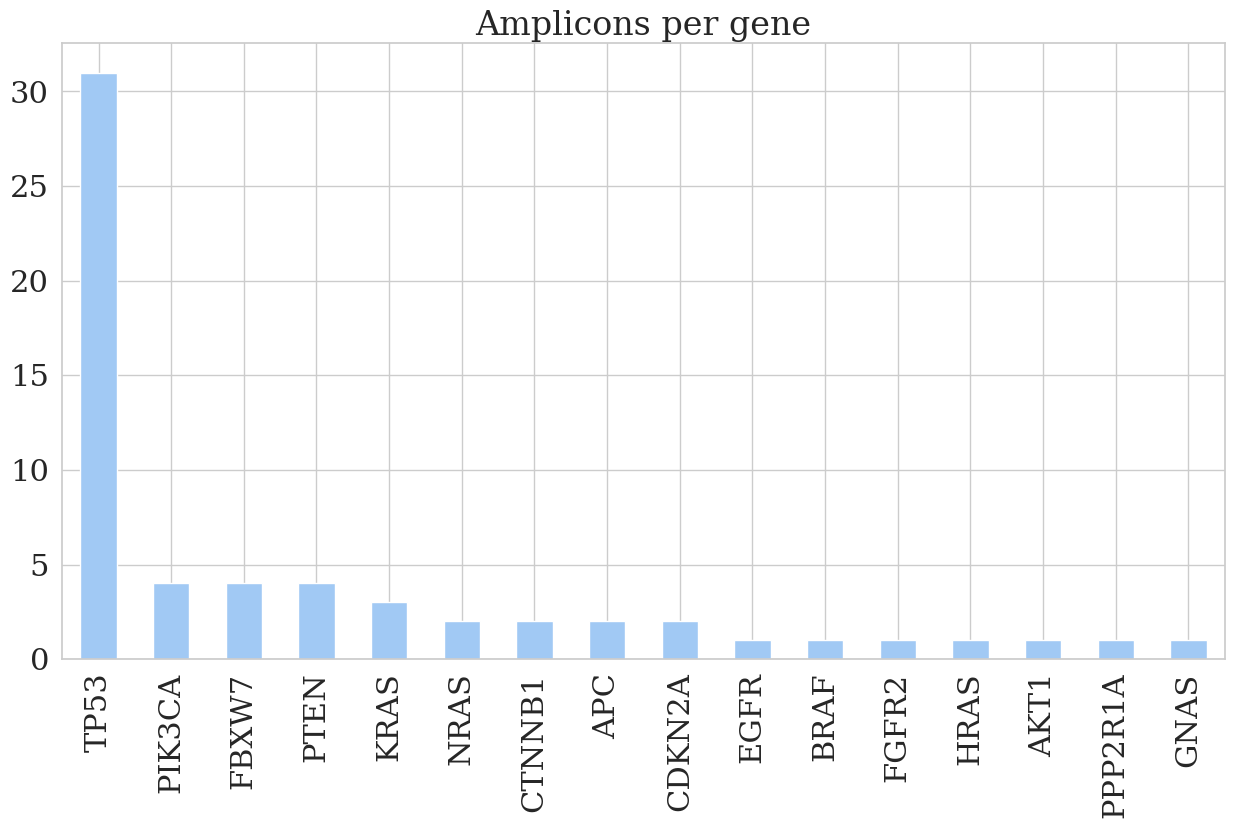

In [53]:
df.Gene.value_counts().plot(
    kind="bar", title="Amplicons per gene", color = colors[0])